# FRC and Image Quality

The though in here was to combine FRC with the image quality ranking mehthod. The dataset that I intended to test it with was corrupted so untested, but should be more or less good to go.

In [7]:
import os
import pandas as pd


import supertomo.ui.image_quality_options as opts

from supertomo.data.io import read
import supertomo.processing.image as imops

import supertomo.analysis.resolution.fourier_ring_correlation as frc
import supertomo.analysis.resolution.analysis as fsc_analysis
from supertomo.analysis.image_quality import filters
import supertomo.data.iterators.fourier_ring_iterators as iterators


from supertomo.data.containers.fourier_correlation_data import FourierCorrelationDataCollection


args_list = ("--use-mask --normalize-power --bin-delta=8 --frc-curve-fit-degree=4" 
             " --resolution-threshold-criterion=snr --resolution-snr-value=0.25 --use-splines").split()

options = opts.get_quality_script_options(args_list)

In [8]:
def evaluate_quality(image, options):
    # Run spatial domain analysis
    task = filters.LocalImageQuality(image, options)
    task.set_smoothing_kernel_size(100)
    entropy = task.calculate_image_quality()

    # Run frequency domain analysis
    task2 = filters.FrequencyQuality(image, options)
    results = task2.analyze_power_spectrum()

    task3 = filters.SpectralMoments(image, options)
    moments = task3.calculate_spectral_moments()

    task4 = filters.BrennerImageQuality(image, options)
    brenner = task4.calculate_brenner_quality()

    # Save results
    results.insert(0, moments)
    results.insert(0, brenner)
    results.insert(0, entropy)
    results.insert(0, os.path.join(path, image_name))
    
    return results

def evaluate_resolution(image, args):
    
    data = FourierCorrelationDataCollection()
    
    image1, image2 = imops.checkerboard_split(image)
    iterator = iterators.FourierRingIterator(image1.shape, args.d_bin)

    frc_task = frc.FRC(image1, image2, iterator)
    data[0] = frc_task.execute()
    
    analyzer = fsc_analysis.FourierCorrelationAnalysis(data, image1.spacing[0], args)
    results = analyzer.execute()[0]
    
    return results.resolution['resolution']
                 

        

In [9]:
df = pd.DataFrame(columns=["Filename", "tEntropy", "tBrenner", "fMoments", "fMean", "fSTD", "fEntropy",
             "fTh", "fMaxPw", "Skew", "Kurtosis", "MeanBin", "Resolution"])

path = "/Users/sami/Documents/Work/Data/2018_05_FSC_paper/STED-Resolution/Crop"

for idx, image_name in enumerate(os.listdir(path)):
    if options.file_filter is None or options.file_filter in image_name:
        real_path = os.path.join(path, image_name)
        # Only process images
        if not os.path.isfile(real_path) or not real_path.endswith((".jpg", ".tif", ".tiff", ".tif")):
            continue
        # ImageJ files have particular TIFF tags that can be processed correctly
        # with the options.imagej switch
        image = read.get_image(real_path, channel=options.rgb_channel)

        # Only grayscale images are processed. If the input is an RGB image,
        # a channel can be chosen for processing.
        results = evaluate_quality(image, options)
        results.append(evaluate_resolution(image, options))
                
        df.loc[idx] = results
        
        
        print "Done analyzing {}".format(image_name)
        

Fit starts at 0.319999992847
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 11
         Function evaluations: 22
Done analyzing APD_STED_90.tif
Fit starts at 0.319999992847
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 10
         Function evaluations: 20
Done analyzing HyD_STED_60.tif
Fit starts at 0.228571429849
Optimization terminated successfully.
         Current function value: 0.000057
         Iterations: 9
         Function evaluations: 18
Done analyzing APD_STED_50.tif
Fit starts at 0.365714281797
Optimization terminated successfully.
         Current function value: 0.000040
         Iterations: 9
         Function evaluations: 18
Done analyzing HyD_STED_70.tif
Fit starts at 0.274285703897
Optimization terminated successfully.
         Current function value: 0.000050
         Iterations: 10
         Function evaluations: 20
Done analyzing APD_STED_80.tif
Fit starts a

In [10]:
df

,Filename,tEntropy,tBrenner,fMoments,fMean,fSTD,fEntropy,fTh,fMaxPw,Skew,Kurtosis,MeanBin,Resolution
0,/Users/sami/Documents/Work/Data/2018_05_FSC_pa...,3.006576,16445852.0,75.978115,42689.833641,783.178909,5.058238,3.433701e+07,42883.125619,-0.104317,-0.183676,42238.145522,0.141875
1,/Users/sami/Documents/Work/Data/2018_05_FSC_pa...,4.388336,27490287.0,34.274005,6996.332267,137.510210,4.946995,3.444886e+07,6991.367961,-0.159866,-0.139950,7054.757962,0.128477
2,/Users/sami/Documents/Work/Data/2018_05_FSC_pa...,3.271495,19053417.0,61.088561,40284.543240,792.898015,4.980712,3.444886e+07,40185.115619,-0.024808,0.197750,40748.088177,0.177113
4,/Users/sami/Documents/Work/Data/2018_05_FSC_pa...,4.290403,24307424.0,40.017420,7046.973912,156.327777,4.960438,3.444886e+07,6989.871961,-0.127957,0.029320,7089.965333,0.117849
5,/Users/sami/Documents/Work/Data/2018_05_FSC_pa...,3.132457,17848738.0,69.452220,41483.731738,857.461187,4.943807,3.444886e+07,41463.316491,-0.120493,-0.007897,41438.224570,0.144921
6,/Users/sami/Documents/Work/Data/2018_05_FSC_pa...,3.889974,21569666.0,47.264357,7095.459438,150.118790,5.069210,3.433701e+07,7094.843446,0.375832,-0.224508,7189.832092,0.107979
7,/Users/sami/Documents/Work/Data/2018_05_FSC_pa...,4.343332,25491774.0,38.862288,7009.765945,150.931010,4.928335,3.444886e+07,6949.089673,-0.156667,0.310518,7188.099577,0.113609
8,/Users/sami/Documents/Work/Data/2018_05_FSC_pa...,3.303435,18973832.0,61.119910,39764.360961,777.629117,5.096147,3.444886e+07,39670.677823,-0.098316,-0.465647,39584.931885,0.145527
9,/Users/sami/Documents/Work/Data/2018_05_FSC_pa...,4.483738,27191132.0,33.395084,6989.648472,156.547250,4.843749,3.444886e+07,6942.009141,0.176953,-0.005881,7024.974099,0.137687
10,/Users/sami/Documents/Work/Data/2018_05_FSC_pa...,3.252563,18927302.0,62.430858,40519.631884,843.954652,4.790510,3.444886e+07,40310.471542,-0.403876,1.193062,40806.736628,0.162363


In [11]:
import numpy as np

df_res = df.sort_values(by=['Resolution']).reset_index(drop=True)

df_res = df_res.loc[:, ["tEntropy", "Resolution", "fSTD"]]

df_res['tEntropy'] -= df_res['tEntropy'].min()
df_res["tEntropy"] /= df_res["tEntropy"].max()

df_res['fSTD'] -= df_res['fSTD'].min()
df_res["fSTD"] /= df_res["fSTD"].max()


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11cfbb3d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1cad1113d0>], dtype=object)

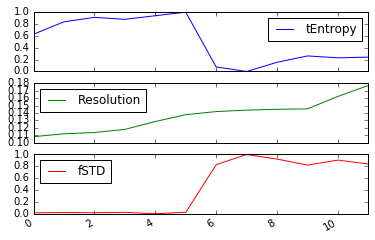

In [12]:
df_res.plot(subplots=True)

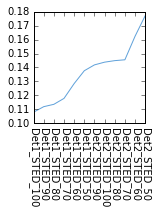

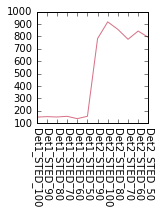

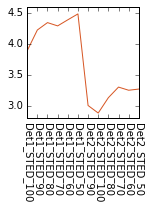

In [15]:
import matplotlib.pyplot as plt


df_sorted = df.sort_values(by=['Resolution']).reset_index(drop=True)



directory = "/Users/sami/Documents/Work/Article manuscripts/2018_FRC:FSC/Data/Figure_Image_Quality"


x_ticks = list(filename.split("/")[-1].split(".")[:-1][0] for filename in df_sorted["Filename"])
x_ticks = list(x.replace("HyD", "Det1").replace("APD", "Det2") for x in x_ticks)

size = (2, 2)
frc_plot = df_sorted.plot(y='Resolution', figsize=size, legend=False, color='#61a2da', xticks=df_sorted.index)
frc_plot.set_xticklabels(x_ticks, rotation = -90)
plt.savefig(os.path.join(directory, "imq_resolution.eps"), 
            dpi=1200, bbox_inches='tight', pad_inches=0, transparent=True)

fstd_plot = df_sorted.plot(y='fSTD', figsize=size, legend=False, color='#d77186', xticks=df_sorted.index)
fstd_plot.set_xticklabels(x_ticks, rotation = -90)
plt.savefig(os.path.join(directory, "imq_fstd.eps"), 
            dpi=1200, bbox_inches='tight', pad_inches=0, transparent=True)

entropy_plot = df_sorted.plot(y='tEntropy', figsize=size, legend=False, color='#D75725', xticks=df_sorted.index)
entropy_plot.set_xticklabels(x_ticks, rotation = -90)
plt.savefig(os.path.join(directory, "imq_tentropy.eps"), 
            dpi=1200, bbox_inches='tight', pad_inches=0, transparent=True)



In [ ]:
for filename in df_sorted["Filename"]:
    print filename.split("/")[-1]


In [ ]:
df_sorted

In [ ]:
string = "HyD_xxxx"

if "HyD" in string:
    string = string.replace("APD", "Det1")
    
print string